In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler
import shap

In [2]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

# dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
# dataset["remarks"] = "No DLC available"
# datasets["ROAD"] = dataset.to_dict("records")

dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv") #, "Malfunction_dataset_SONATA")
dataset["remarks"] = "-"
datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dcs_ID,dt,dt_ID,dt_data,name,class,dataset,type,Label
0,0.369422,0.078324,0.000444,0.009978,0.724212,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
1,0.453125,0.025104,0.000232,0.009977,0.045600,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
2,0.343750,0.000896,0.000248,0.009981,0.009991,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
3,0.328125,0.008395,0.000234,0.009978,0.047617,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
4,0.375000,0.038187,0.000241,0.009978,0.036785,Fuzzy_dataset_SONATA,Sonata,Survival,fuzz,0
...,...,...,...,...,...,...,...,...,...,...
1735835,0.187500,0.000000,0.000248,0.020620,0.020620,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735836,0.265625,0.000000,0.000235,0.013305,0.013305,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735837,0.312500,0.000000,0.000242,0.013092,0.013092,FreeDrivingData_20171231_Spark,Spark,Survival,none,0
1735838,0.265625,0.000000,0.000435,0.012329,0.012329,FreeDrivingData_20171231_Spark,Spark,Survival,none,0


In [3]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [4]:
# from sklearn.preprocessing import StandardScaler, RobustScaler

# X_train_original = df.copy()

# feature_columns= list(set(df.columns.to_list()).difference(["name", "class", "dataset", "type", "Label"]))

# for col in feature_columns:
#     scaler = RobustScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
#     df.loc[:, df.columns == col] = scaler.transform(df.loc[:, df.columns == col])

# from pp_tools import scale_dataset
# df_original = df.drop(columns=["type", "dataset", "name", "class", "Label"]).copy()
# scale_dataset(df)
# display(df)

In [5]:
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the name of the dataset
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [6]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		128216		55098
Attack		128216		55098


In [7]:
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True, errors="ignore")
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True, errors="ignore")

Deep Neural Network

In [8]:
from pp_tools import scale_dataset

X_train_original = X_train.copy()

X_combined = pd.concat([X_train, X_test])

scale_dataset(X_combined)

test_len = len(X_test)
X_test = X_combined.iloc[-test_len:]
X_train = X_combined.iloc[:-test_len]

X_combined = None # Release memory

In [9]:
import keras
from keras import layers
# from tensorflow import keras
# from keras import layers

dnn = keras.models.Sequential(
    [
        keras.Input(shape=(len(X_train.columns),), name="input"),
        layers.Dense(11, activation='relu', name="layer_1", kernel_initializer="glorot_normal"),
        layers.Dense(23, activation='relu', name="layer_2", kernel_initializer="glorot_normal"),
        layers.Dense(7, activation='relu', name="layer_3", kernel_initializer="glorot_normal"),
        layers.Dense(1, activation='sigmoid', name="output", kernel_initializer="glorot_normal")
    ]
)



dnn.compile(
    optimizer="adam",  # Optimizer rmsprop
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(), keras.metrics.Recall(), keras.metrics.FalseNegatives()],
)



val_percent = int(len(y_train) * 0.1)
X_val = X_train.sample(val_percent, random_state=0)
y_val = y_train.loc[X_val.index]
X_train = X_train.loc[~X_train.index.isin(X_val)]
y_train = y_train.loc[~y_train.index.isin(X_val)]

dnn.fit(
    X_train,
    y_train,
    batch_size=200,
    epochs=10,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
    callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)]
)

# results = dnn.evaluate(X_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

Epoch 1/10
1283/1283 [==============================] - 2s 1ms/step - loss: 0.3900 - binary_accuracy: 0.8028 - recall: 0.8427 - false_negatives: 20164.0000 - val_loss: 0.3100 - val_binary_accuracy: 0.8510 - val_recall: 0.9200 - val_false_negatives: 1027.0000
Epoch 2/10
1283/1283 [==============================] - 1s 993us/step - loss: 0.2899 - binary_accuracy: 0.8638 - recall: 0.9233 - false_negatives: 9833.0000 - val_loss: 0.2756 - val_binary_accuracy: 0.8752 - val_recall: 0.9097 - val_false_negatives: 1158.0000
Epoch 3/10
1283/1283 [==============================] - 1s 1ms/step - loss: 0.2592 - binary_accuracy: 0.8815 - recall: 0.9316 - false_negatives: 8768.0000 - val_loss: 0.2445 - val_binary_accuracy: 0.8814 - val_recall: 0.9214 - val_false_negatives: 1009.0000
Epoch 4/10
1283/1283 [==============================] - 1s 1ms/step - loss: 0.2357 - binary_accuracy: 0.8964 - recall: 0.9484 - false_negatives: 6622.0000 - val_loss: 0.2244 - val_binary_accuracy: 0.9284 - val_recall: 0.984

In [10]:
pred_train = np.round(dnn.predict(X_train))

f1_scores = f1_score(y_train, pred_train, average='weighted')
print("Training F1:  %0.4f (+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

pred_test = np.round(dnn.predict(X_test))

f1_scores = f1_score(y_test, pred_test, average='weighted')
print("Testing F1:  %0.4f (+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred_test)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1:  0.9937 (+/- 0.0000)
Testing F1:  0.9936 (+/- 0.0000)
Kappa score:  0.9872(+/- 0.0000)


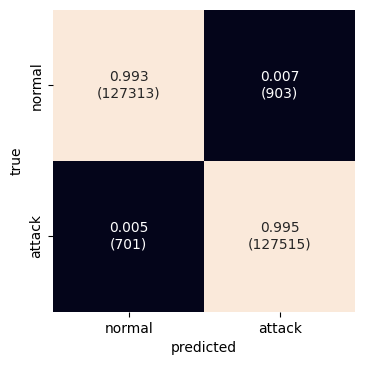

In [11]:
from plot_tools import plot_confusion_matrix

plot_confusion_matrix(y_train, pred_train, "DNN, \"Survival\", all attacks, training data\n(# of instances)", cbar=False)

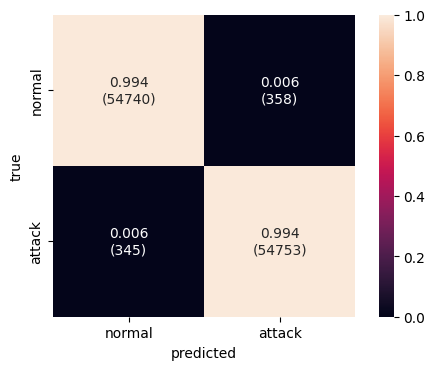

In [12]:
plot_confusion_matrix(y_test, pred_test, "DNN, \"Survival\", all attacks, testing data\n(# of instances)")

In [13]:
import shap

exp = shap.KernelExplainer(dnn, data=X_train.sample(100, random_state=1))
print(exp.expected_value)

[0.45865257]


In [14]:
from shap_tools import *

X_exp = X_train.sample(min(len(X_train), 600), random_state=0)
y_exp = y_train[X_exp.index]
X_exp_original = X_train_original.loc[X_exp.index]
print(X_exp)
print(X_exp_original)

# Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# same predictions as the original model
# assert np.abs(exp.model.predict(X_exp) - dnn.predict_proba(X_exp)).max() < 1e-4


# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs((shap_all.base_values + shap_all.values).sum(1) - clf.predict_proba(X_train)).max() < 1e-4

# print(len(X_train.loc[y_train != pred]))
# print(len(X_train.loc[y_train == pred]))
# shap_false = get_explanation(exp, X_train.loc[y_train != pred])
# shap_FP = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 1)])
# shap_FN = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 0)])
# shap_true = get_explanation(exp, X_train.loc[y_train == pred])
# shap_TP = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 1)])
# shap_TN = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 0)])

             dcs    dcs_ID        dt     dt_ID   dt_data
25509   0.684588 -0.645970 -0.306677 -0.253748 -0.268738
33021   0.202106  0.152883 -0.074588 -0.257759 -0.049461
80154   0.395099 -0.486199 -0.348614 -0.256185  0.855245
196895  0.974077  1.848227 -0.218988  2.782371  0.221982
224807 -2.113809 -0.645970  0.033116 -0.261582 -0.269421
...          ...       ...       ...       ...       ...
190395  0.491595  2.469557  1.214049  2.784244  0.004532
222010  0.009113 -0.645970 -0.338607 -0.261446 -0.269339
216292  0.877581  2.309786 -0.388646 -0.080556  0.221982
2314   -0.087384 -0.486199 -0.356716 -0.257182 -0.226268
83088  -2.017313 -0.645970 -0.322880 -0.256898 -0.266583

[600 rows x 5 columns]
             dcs    dcs_ID        dt     dt_ID   dt_data
25509   0.453125  0.000000  0.000261  0.017981  0.002958
33021   0.375000  0.156250  0.000377  0.008996  0.813642
80154   0.406250  0.031250  0.000240  0.012522  4.158411
196895  0.500000  0.487847  0.000305  6.820059  1.817189
224807 

In [15]:
shap_all = get_explanation(exp, X_exp)

100%|██████████| 600/600 [00:20<00:00, 29.73it/s]


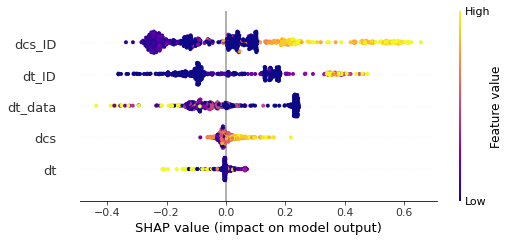

In [16]:
plot_beeswarm(shap_all)

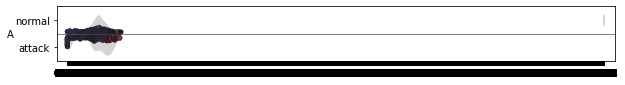

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fc77161bee0> (for post_execute):


KeyboardInterrupt: 

In [57]:
import matplotlib
def plot_test(df_exp: pd.DataFrame, shap_all: shap.Explanation, feature, trim=None, y_squish=10, scale=1, colorbar=False, y_size=1):
    df_exp["Label"].replace({0: "normal", 1: "attack"}, inplace=True)
    shap_exp = shap_all.values[:,df_exp.columns.get_loc(feature)]

    mask = None
    if trim == None:
        mask = (np.abs(stats.zscore(df_exp[feature])) < 3)
    else:
        mask = (df_exp[feature] > trim[0]) & (df_exp[feature] < trim[1])

    attack_outliers = shap_exp[~mask & (df_exp["Label"] == "attack")]
    normal_outliers = shap_exp[~mask & (df_exp["Label"] == "normal")]

    shap_exp = shap_exp[mask]
    df_exp = df_exp[mask]

    # plt.figure(figsize=(20, 2), dpi=100)
    # plt.figure(80, y_squish)
    # fig = plt.figure() 
    # ax = fig.add_axes([0, 0, 80, y_squish])
    fig, ax = plt.subplots(figsize=(80, y_squish))
    
    cmap_name = "icefire"
    violin_color = "lightgray"

    scaler = max(abs(shap_exp.min()), abs(shap_exp.max()))
    shap_hues = shap_exp / scaler
    shap_hues = (shap_hues + 1) * shap_all.base_values[0]

    if attack_outliers.size != 0:
        attack_outliers /= max(abs(attack_outliers.min()), abs(attack_outliers.max()))
        attack_outliers = (attack_outliers + 1) * shap_all.base_values[0]

    if normal_outliers.size != 0:
        normal_outliers /= max(abs(normal_outliers.min()), abs(normal_outliers.max()))
        normal_outliers = (normal_outliers + 1) * shap_all.base_values[0]
    
    cmap = sns.color_palette(cmap_name, as_cmap=True)
    norm = plt.Normalize(vmin=0, vmax=1)
    palette = {h: cmap(h) for h in shap_hues}

    values = df_exp[feature]
    feature_min = values.min()
    feature_max = values.max()
    values = (values - values.min()) / (values.max() - values.min())
    label = df_exp["Label"]

    sns.swarmplot(x=values, y=label, order=["normal", "attack"],
        hue=shap_hues, orient="h", palette=palette,
        size=5)
    
    # Change offset on dots for normal (0)
    offsets = ax.collections[0].get_offsets()
    offsets = [[elem[0], -abs(elem[1] - 0) - 0.03] for elem in offsets]
    ax.collections[0].set_offsets(offsets)

    # Change offset on dots for attack (1)
    offsets = ax.collections[1].get_offsets()
    offsets = [[elem[0], abs(elem[1] - 1) + 0.07] for elem in offsets]
    ax.collections[1].set_offsets(offsets)

    fig.set_size_inches(10, y_size)

    sns.violinplot(x=values, y=[0]*label.size, hue=label, split=True, hue_order=["normal", "attack"],
        orient="h",  showfliers=False, scale="count", bw=0.2, gridsize=1000, linewidth=0, color=violin_color,
        cut=0, inner=None)
    
    for violin in ax.findobj(matplotlib.collections.PolyCollection):
        violin.set_facecolor("lightgray")
    
    ax.legend_.remove()

    if colorbar:
        cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap_name), label="contribution", location="bottom", shrink=0.2, anchor=(0.95, -1))
        cbar.set_ticks([0, 0.5, 1])
        cbar.set_ticklabels(["towards\nnormal", "none", "towards\nattack"])

    f_dict = {"dcs": "A", "dcs_ID": "B", "dt": "C", "dt_ID": "D", "dt_data": "E"}
    feature = f_dict[feature]
    # ax.set_title(f"How the RF-model classifies data - feature: {feature}")
    # ax.set_title(feature)
    # feature = feature + " (ms)" if feature[0:2] == "dt" else feature

    # ax.set_ylabel("type of data")
    ax.set_ylabel(feature, rotation="horizontal", x=-1, y=0.4)
    # ax.set_xlabel(f"value of {feature}")
    ax.set_xlabel("")

    ax.set_xticks(ticks=np.linspace(0, 1, 10), labels=map(lambda x: format(x*scale, '.2f'), np.linspace(feature_min, feature_max, 10)))
    ax.set_yticks(ticks=[-0.25, 0.25], labels=["normal", "attack"])
    ax.axhline(y=0, color="black", linewidth=0.5)
    
    s_last = ax.get_xticks()[-2]
    last = ax.get_xticks()[-1]
    
    if normal_outliers.size != 0:
        ax.arrow(last + (last-s_last) * 0.5, -0.25, last-s_last, 0, facecolor=cmap(normal_outliers.mean()), edgecolor=violin_color,
            width=0.07, head_length=(last-s_last)*0.7, head_width=0.2,
            length_includes_head=True)
    if attack_outliers.size != 0:
        ax.arrow(last + (last-s_last) * 0.5, 0.25, last-s_last, 0, facecolor=cmap(attack_outliers.mean()), edgecolor=violin_color,
            width=0.07, head_length=(last-s_last)*0.7, head_width=0.2,
            length_includes_head=True)
    
    ax.margins(x=0.02)
    
    # return ax
    plt.show()

plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs", trim=(-1, 0.7), y_squish=25)
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs_ID", trim=(0, 0.8), y_squish=15)
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt", trim=(0, 0.0003), scale=1000, y_squish=20)
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_ID", trim=(0, 0.02), scale=1000)
plot_test(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_data", trim=(0, 0.02), scale=1000, colorbar=True, y_size=1.5)

In [15]:
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_ID", trim=(0, 0.02), scale=1000)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt_data", trim=(0, 0.02), scale=1000)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dt", trim=(0, 0.0003), scale=1000, y_squish=20)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs", trim=(-1, 0.7), y_squish=25)
plot_exp(pd.concat([X_exp_original, y_exp], axis=1), shap_all, "dcs_ID", trim=(0, 1), y_squish=10)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: cannot reindex on an axis with duplicate labels

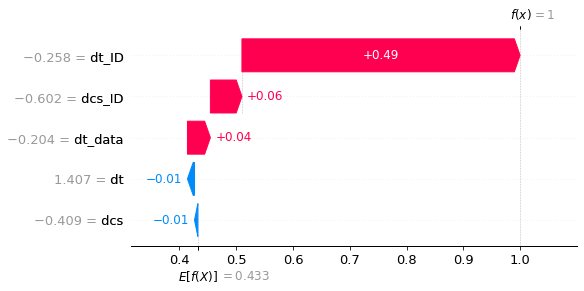

In [16]:
plot_waterfall(shap_all, 0)

In [17]:
plot_force(shap_all[0])

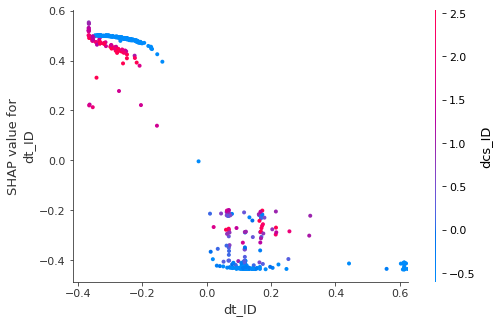

In [18]:
plot_dependence(shap_all, "dt_ID", "dcs_ID", xmax="percentile(99)")

In [19]:
dnn_layer_1 = keras.Model(inputs=dnn.input, outputs=dnn.get_layer("layer_3").output)

dnn_layer_1.predict(X_train)

array([[0.        , 2.0680475 , 0.        , ..., 0.        , 2.3630352 ,
        2.243791  ],
       [0.        , 1.7100167 , 0.        , ..., 0.        , 1.809918  ,
        1.7536744 ],
       [0.17535664, 1.4493308 , 0.        , ..., 0.        , 1.5298315 ,
        1.5848781 ],
       ...,
       [2.3730376 , 0.11246863, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.5577636 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.6439602 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [20]:
exp_layer_1 = shap.KernelExplainer(dnn_layer_1, data=X_train.sample(100, random_state=1))

In [21]:
shap_all_layer_1 = get_explanation(exp_layer_1, X_train, 100)

TypeError: get_explanation() takes 2 positional arguments but 3 were given

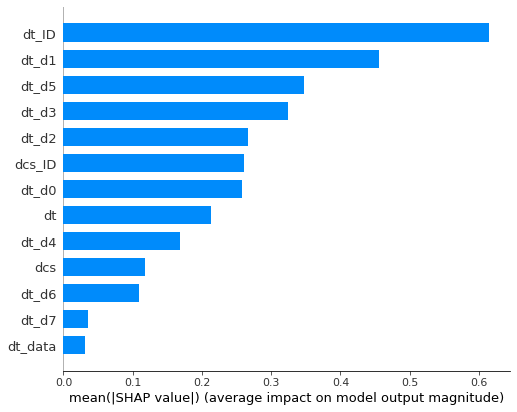

In [ ]:
# print(shap_all_layer_1)
shap.summary_plot(shap_all_layer_1, X_test, plot_type="bar")